In [1]:
import symforce
symforce.set_epsilon_to_symbol()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import vo
# pose_metrics requires evo (see top of pose_metrics.py for install instructions)
import pose_metrics
import utils

# Note: this notebook requires pandas in addition to all of Prof. Bretl's dependencies
import pandas as pd

### Provide settings

In [2]:
# When matching (max threshold for ratio test)
matching_threshold = 0.5

# When deciding if triangulated points are invalid
max_reprojection_err = 0.75

# MAV video folder
mav_video_folder = Path('./data/mav0')

# Temporary folder for evo metrics
temporary_folder = Path('./temp')
temporary_folder.mkdir(parents=True, exist_ok=True)

### Read data

In [3]:
cam0_sensor = utils.read_yaml(mav_video_folder / 'cam0/sensor.yaml')

cam0_K = np.array([
    [cam0_sensor['intrinsics'][0], 0, cam0_sensor['intrinsics'][2]],
    [0, cam0_sensor['intrinsics'][1], cam0_sensor['intrinsics'][3]],
    [0, 0, 1]
])
cam0_distortion = np.array(cam0_sensor['distortion_coefficients'])
cam0_resolution = np.array(cam0_sensor['resolution']) # W,H
cam0_extrinsics = np.array(cam0_sensor['T_BS']['data']).reshape(4,4)

In [4]:
imu_sensor = utils.read_yaml(mav_video_folder / 'imu0/sensor.yaml')

imu_extrinsics = np.array(imu_sensor['T_BS']['data']).reshape(4,4)
imu_gyroscope_noise_density = imu_sensor['gyroscope_noise_density']
imu_gyroscope_random_walk = imu_sensor['gyroscope_random_walk']
imu_accelerometer_noise_density = imu_sensor['accelerometer_noise_density']
imu_accelerometer_random_walk = imu_sensor['accelerometer_random_walk']

In [5]:
cam0_csv = pd.read_csv(mav_video_folder / 'cam0/data.csv')
imu0_csv = pd.read_csv(mav_video_folder / 'imu0/data.csv')
states_csv = pd.read_csv(mav_video_folder / 'state_groundtruth_estimate0/data.csv')
visual_inertial_data = utils.collect_visual_inertial_data(imu0_csv, cam0_csv, states_csv, mav_video_folder / Path('cam0/data'))

### Create random generator

In [6]:
rng = utils.create_rng(None)

seeding RNG with 1260027359


### Create image keypoint feature extractor

In [7]:
feature_extractor = cv2.SIFT_create() # could also do ORB_create() for ORB features

### Two view reconstruction

Get initial solution

In [8]:
chosen_index = 0

# Get first index closest to chosen index
first_frame_idx = utils.get_index_of_next_image(visual_inertial_data, chosen_index)
# Get second index
second_frame_idx = utils.get_index_of_next_image(visual_inertial_data, first_frame_idx+1)

# Create two views
views = [
    vo.create_view_data(utils.read_image_mav(visual_inertial_data[first_frame_idx]['image_file']),
                        first_frame_idx, feature_extractor, cam0_K, cam0_distortion),
    vo.create_view_data(utils.read_image_mav(visual_inertial_data[second_frame_idx]['image_file']),
                        second_frame_idx, feature_extractor, cam0_K, cam0_distortion)
]

# Perform two-view reconstruction
tracks = vo.vo_2view(views, matching_threshold, cam0_K, rng, use_opencv=False)

found 601 good matches
found 527 inliers



REPROJECTION ERRORS
 Image  0 (  601 points) : (mean, std, max, min) = (  0.29,   0.67,  10.27,   0.00)
 Image (raw reprojection)  0 (  601 points) : (mean, std, max, min) = (  0.25,   0.55,   8.95,   0.00)
 Image  1 (  601 points) : (mean, std, max, min) = (  0.29,   0.66,  10.12,   0.00)
 Image (raw reprojection)  1 (  601 points) : (mean, std, max, min) = (  0.23,   0.55,   8.93,   0.00)


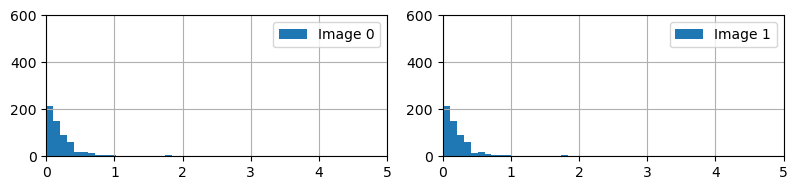

In [9]:
vo.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)

Get post-optimization solution

In [10]:
views, tracks = vo.vo_nonlinear_optimize(views, tracks, cam0_K, max_reprojection_err)

/Users/andre/mambaforge/envs/ae598-3dv/lib/python3.12/site-packages/symforce/opt/optimizer.py:267: FutureWarning: debug_stats argument is deprecated, use params.debug_stats
  warnings.warn(


[2024-04-24 11:14:54.723] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 8.728e+01/8.278e+01/8.268e+01, rel reduction: 5.26956e-02, gain ratio: 1.02237e+00
[2024-04-24 11:14:55.269] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 8.268e+01/7.650e+01/7.606e+01, rel reduction: 8.00591e-02, gain ratio: 1.07082e+00
[2024-04-24 11:14:55.749] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 7.606e+01/7.223e+01/7.378e+01, rel reduction: 2.99361e-02, gain ratio: 5.94365e-01
[2024-04-24 11:14:56.283] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 7.378e+01/7.011e+01/7.164e+01, rel reduction: 2.90871e-02, gain ratio: 5.84941e-01
[2024-04-24 11:14:56.690] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 7.164e+01/6.817e+01/7.019e+01, rel reduction: 2.01821e-02, gain ratio: 4.16752e-01
[2024-04-24 11:14:57.148] [info] LM<sym::Optimize> [iter    


REPROJECTION ERRORS
 Image  0 (  576 points) : (mean, std, max, min) = (  0.12,   0.14,   0.70,   0.00)
 Image (raw reprojection)  0 (  576 points) : (mean, std, max, min) = (  0.12,   0.12,   0.60,   0.00)
 Image  1 (  576 points) : (mean, std, max, min) = (  0.13,   0.14,   0.73,   0.00)
 Image (raw reprojection)  1 (  576 points) : (mean, std, max, min) = (  0.12,   0.13,   0.65,   0.00)


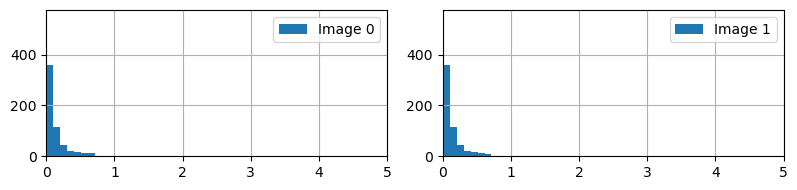

In [11]:
vo.show_reproj_results(views, tracks, cam0_K, cam0_distortion, print_raw_reproj=True, show_reproj_histogram=True)

### Compute APE - example
Note, because we only have 2 views we don't have sufficient data to actually do an alignment.

In [12]:
ape_results = pose_metrics.compute_ape(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    temporary_folder / Path('traj1.txt'),
    temporary_folder / Path('traj2.txt'),
    temporary_folder / Path('results.zip'),
    temporary_folder / Path('results/'),
    align='none', verbose=False, print_results=True,
)


APE EVALUATION (alignment = none)
rmse = 5.285
mean = 5.281
median = 5.281
std = 0.201
min = 5.080
max = 5.482
sse = 55.858


### Compute pose error (with my alignment) example
Basically, we do a coordinate transform so both trajectories start at 0 pose and identity rotation. Then we calculate the error for each time-step. In our case, we probably should just care about the final error elements (which specifies errors between first and last frame).

In [13]:
pose_results = pose_metrics.compute_pose_error(
    pose_metrics.create_tum_data_from_views(times=[visual_inertial_data[view['frame_id']]['time'] for view in views], views=views),
    pose_metrics.create_tum_data_from_groundtruth([visual_inertial_data[view['frame_id']] for view in views]),
    align='posescale', print_results=True,
)

Avg error in translation = 0.494 (min = 0.000, max = 0.988, final = 0.988)
Avg error in rotation = 0.015 (min = 0.000, max = 0.030, final = 0.030)
